In [187]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob



In [ ]:
matched_up_dir='/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/match_aeronet_viirs6hours_TW/' #finding pairs in MATCH_TIME_WINDOW = 6.0; 
plots_dir='/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/plots/'

Functions

In [307]:
def plot_relationship(
    df, x_col, y_col, hue_col=None, title="", xlabel="", ylabel="", 
    legend_title=None, legend_loc="best", legend_ncols=1, legend_bbox_to_anchor=None, 
    save_path=None,one_one_line=True, regression=True,plot_error_bar=False, xlim=None, ylim=None, alpha=0.5, figsize=(10, 6), fontsize=12, palette=None, ax=None
):
    """
    Create a scatter plot with optional regression line, equation, R², and customizable palette.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - x_col (str): Column name for the x-axis.
    - y_col (str): Column name for the y-axis.
    - hue_col (str, optional): Column name for the hue (color grouping).
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - legend_title (str, optional): Title for the legend.
    - legend_loc (str): Location of the legend (e.g., 'upper left', 'best').
    - legend_ncols (int): Number of columns in the legend.
    - legend_bbox_to_anchor (tuple, optional): Position of the legend relative to the plot.
    - save_path (str, optional): Path to save the plot as a file.
    - regression (bool): Whether to include a regression line.
    - xlim (tuple, optional): Limits for the x-axis (min, max).
    - ylim (tuple, optional): Limits for the y-axis (min, max).
    - alpha (float): Transparency of the scatter points.
    - figsize (tuple): Size of the plot (width, height).
    - fontsize (int): Font size for labels, title, and legend.
    - palette (str or list, optional): Color palette for the plot. If None, a random discrete palette is used.
    - ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, a new figure is created.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Create scatter plot
    sns.scatterplot(
        x=x_col, y=y_col, hue=hue_col, data=df, alpha=alpha, palette=palette, ax=ax
    )
    # one to one line
    if one_one_line:
        x_one=np.linspace(0, xlim[1], 100)
        y_one=x_one
        ax.plot(x_one, y_one, color='black', linestyle='--', label='1:1 Line')
    # Add regression line and equation if requested
    if regression:
        slope, intercept = np.polyfit(df[x_col], df[y_col], 1)
        x = np.linspace(df[x_col].min(),xlim[1], 100)
        y = slope * x + intercept
        ax.plot(x, y, color='red', linestyle='--', label=f'Y = {slope:.2f}X + {intercept:.2f}')
        
        # Calculate correlation coefficient and R²
        correlation = df[x_col].corr(df[y_col])
        r_squared = correlation**2
        
        # Add regression equation and R² to the plot
        ax.text(
            0.05, 0.95, f'Y = {slope:.2f}X + {intercept:.2f}', 
            transform=ax.transAxes, fontsize=fontsize
        )
        ax.text(
            0.05, 0.90, f'R² = {r_squared:.2f}', 
            transform=ax.transAxes, fontsize=fontsize
        )
        
    # Add error bars if requested
    if plot_error_bar:
        # Bin the data into intervals of 0.1 along the x-axis
        bins = np.arange(df[x_col].min(), df[x_col].max() + 0.1, 0.1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        means = []
        stds = []
        
        for i in range(len(bins) - 1):
            bin_data = df[(df[x_col] >= bins[i]) & (df[x_col] < bins[i + 1])]
            means.append(bin_data[y_col].mean())
            stds.append(bin_data[y_col].std())
        
        # Plot error bars
        ax.errorbar(bin_centers, means, yerr=stds, fmt='o', color='black', capsize=3, label='STD')
        # also estiamte the equation of how std values change with x (AOD)
        stds = np.array(stds)
        bin_centers = bin_centers[~np.isnan(stds)]
        stds = stds[~np.isnan(stds)]
        slope_std, intercept_std = np.polyfit(bin_centers, stds, 1)
        #add a text for this equation
        ax.text(
            0.05, 0.85, f'Std = {slope_std:.2f}X + {intercept_std:.2f}', 
            transform=ax.transAxes, fontsize=fontsize
        )
    # add a text number of data points
    n_data_points = len(df)
    ax.text(
        0.05, 0.8, f'N = {n_data_points}', 
        transform=ax.transAxes, fontsize=fontsize
    )
    # Set the grid
    #grid off
    ax.grid(False)
    # Add labels and title
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    
    # Set axis limits if provided
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    
    # Adjust legend
    if hue_col and legend_title:
        ax.legend(
            title=legend_title, 
            bbox_to_anchor=legend_bbox_to_anchor, 
            loc=legend_loc, 
            ncol=legend_ncols, 
            fontsize=fontsize
        )
    
    # Save the plot if a path is provided
    if save_path and ax is None:  # Only save if a new figure was created
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
    
    # Show the plot if a new figure was created
    if ax is None:
        plt.show()

Read data

In [247]:
#read all the files in the matched_up directory


matched_up_files=glob(matched_up_dir+'*.csv')
matched_up_files.sort()

#READ EACH FILE IN PANDAS AND CONCATENATE
matched_up_df=pd.DataFrame()
for file in matched_up_files:
    df=pd.read_csv(file)
    matched_up_df=pd.concat([matched_up_df,df],ignore_index=True)
matched_up_df['date']=matched_up_df['date'].astype(str)
#IF aerMean550 is -999 exclude the row
matched_up_df=matched_up_df[matched_up_df['aerMean550'] != -999]


In [248]:
# matched_up_files[0:100]

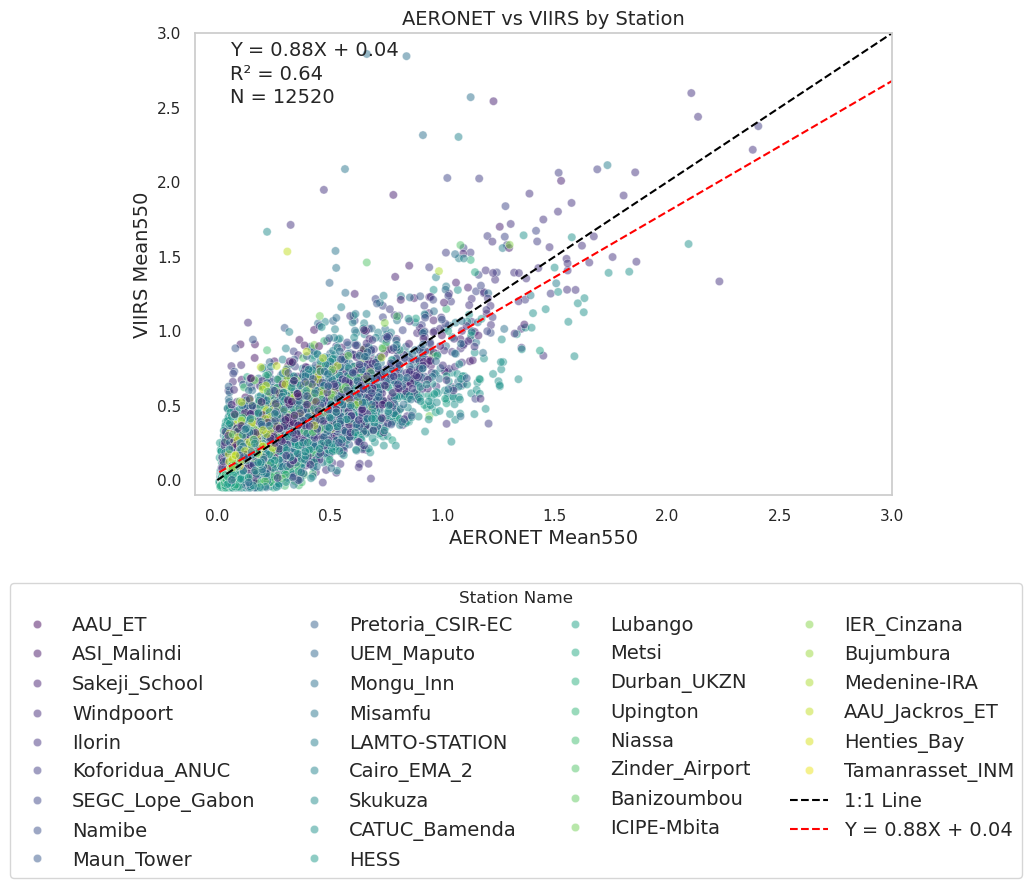

In [252]:
#make scatter plots of the aerMean550 satMean550 color by staName

plot_relationship(
    df=matched_up_df,
    x_col='aerMean550',
    y_col='satMean550',
    hue_col='staName',
    title='AERONET vs VIIRS by Station',
    xlabel='AERONET Mean550',
    ylabel='VIIRS Mean550',
    legend_title='Station Name',
    legend_loc='lower right',
    legend_bbox_to_anchor = (1.2, -0.85),
    legend_ncols=4,
    palette='viridis',
    save_path=os.path.join(plots_dir, 'aeronet_vs_viirs_bysation.png'),
    regression=True,
    xlim =(-0.1, 3),
    ylim =(-0.1, 3),
    figsize =(9,6),
    fontsize=14,
    alpha=0.5
)

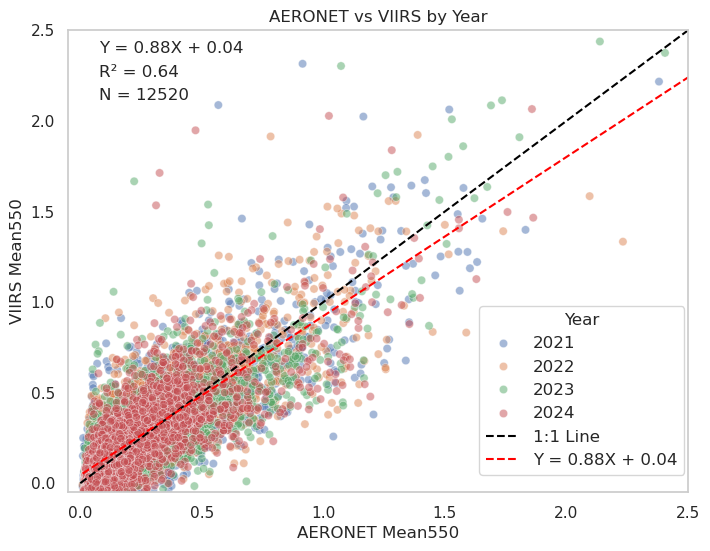

In [253]:
#make scatter plots of the aerMean550 satMean550 color by year
matched_up_df['year']=matched_up_df['date'].str[:4]
plot_relationship(
    df=matched_up_df,
    x_col='aerMean550',
    y_col='satMean550',
    hue_col='year',
    title='AERONET vs VIIRS by Year',
    xlabel='AERONET Mean550',
    ylabel='VIIRS Mean550',
    legend_title='Year',
    legend_loc='lower left',
    legend_bbox_to_anchor=(0.65, 0.02),
    legend_ncols=1,
    save_path=os.path.join(plots_dir, 'aeronet_vs_viirs_byyear.png'),
    regression=True,
    xlim=(-0.05, 2.5),
    ylim=(-0.05, 2.5),
    figsize=(8, 6),
    fontsize=12,
    alpha=0.5
)



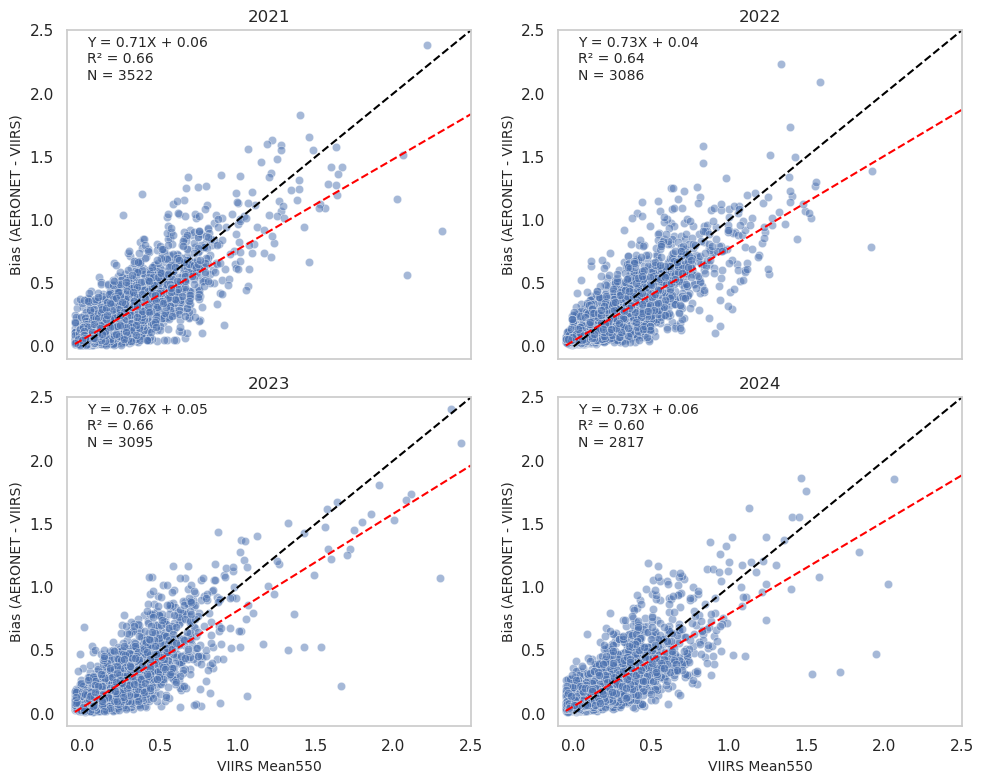

In [254]:
# Ensure the 'year' column exists in the DataFrame
matched_up_df['year'] = matched_up_df['date'].str[:4]  # Extract year from the 'date' column
unique_years = matched_up_df['year'].unique()
unique_years.sort()

# Create subplots for each year
fig, axes = plt.subplots(nrows=int(len(unique_years)/2), ncols=2, figsize=(10, 2 * len(unique_years)), sharex=True)
axes=axes.ravel()

# Loop through each year and call the plot_relationship function
for i, year in enumerate(unique_years):
    ax = axes[i] if len(unique_years) > 1 else axes  # Handle single subplot case
    year_data = matched_up_df[matched_up_df['year'] == year]  # Filter data for the current year
    
    # Call the plot_relationship function for the current year
    plot_relationship(
        ax=ax,
        df=year_data,
        x_col='satMean550',
        y_col='aerMean550',
        title=f' {year}',
        xlabel='VIIRS Mean550',
        ylabel='Bias (AERONET - VIIRS)',
        legend_title=None,
        legend_loc='upper right',
        legend_bbox_to_anchor=None,
        legend_ncols=1,
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-0.1, 2.5),
        alpha=0.5,
        figsize=(6, 6),
        fontsize=10,
        palette=None  # Use default random discrete colors
    )
    ax.set_title(f'{year}', fontsize=12)
# Adjust layout and save the figure
plt.tight_layout()
# plt.savefig('bias_vs_viirs_by_year_subplots.png', dpi=300)
plt.show()

slope_std: 0.13488154499763885, intercept_std: 0.12272045740901263


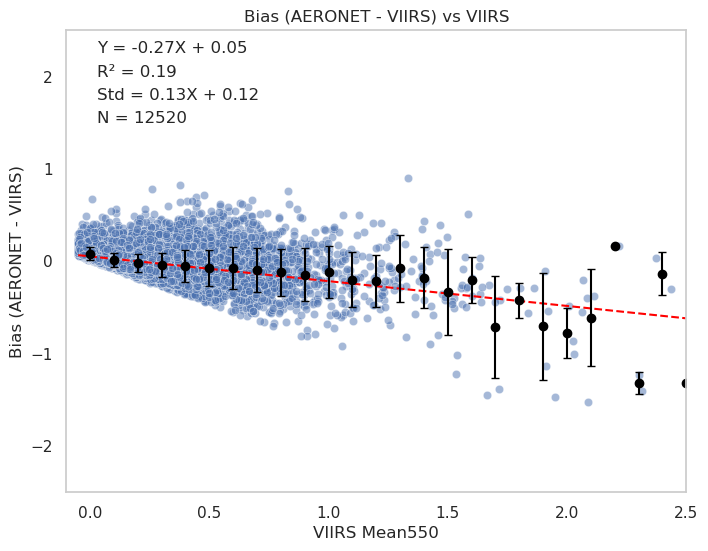

In [308]:
# Calculate the bias (AERONET - VIIRS)
matched_up_df['bias'] = matched_up_df['aerMean550'] - matched_up_df['satMean550']
plot_relationship(
    df=matched_up_df,
    x_col='satMean550',
    y_col='bias',
    title='Bias (AERONET - VIIRS) vs VIIRS',
    xlabel='VIIRS Mean550',
    ylabel='Bias (AERONET - VIIRS)',
    plot_error_bar=True,
    one_one_line=False,
    legend_title=None,
    legend_loc='upper right',
    regression=True,
    xlim=(-0.1, 2.5),
    ylim=(-2.5, 2.5),
    alpha=0.5,
    figsize=(8, 6),
    fontsize=12,
    palette=None
)



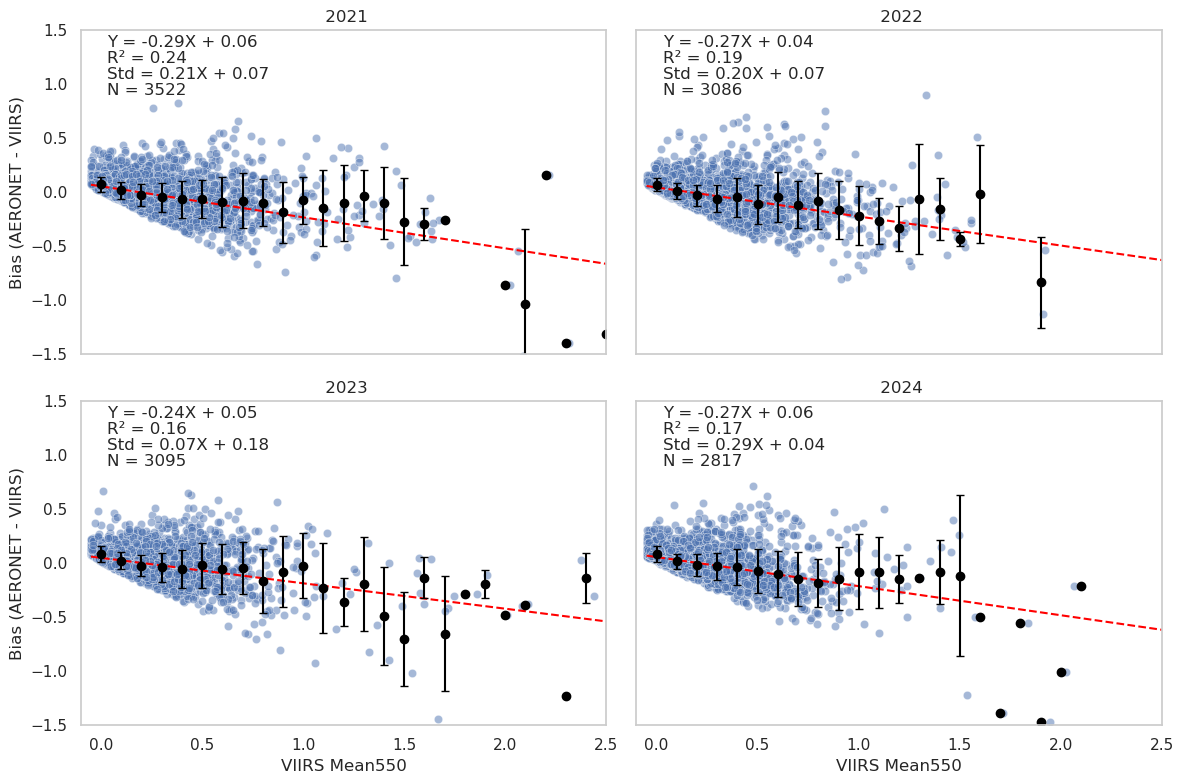

In [309]:
# Ensure the 'year' column exists in the DataFrame
unique_years = matched_up_df['year'].unique()
unique_years.sort()

# Create subplots for each year
fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_years) / 2)), ncols=2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

# Loop through each year and plot the bias
for i, year in enumerate(unique_years):
    ax = axes[i]
    year_data = matched_up_df[matched_up_df['year'] == year]
    
    #call the plot_relationship function for the current year
    plot_relationship(
        ax=ax,
        df=year_data,
        x_col='satMean550',
        y_col='bias',
        title=f' {year}',
        xlabel='VIIRS Mean550',
        ylabel='Bias (AERONET - VIIRS)',
        one_one_line=False,
        plot_error_bar=True,
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-1.5, 1.5),
        alpha=0.5,
        figsize=(6, 6),
        fontsize=12,
        palette=None
    )


# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

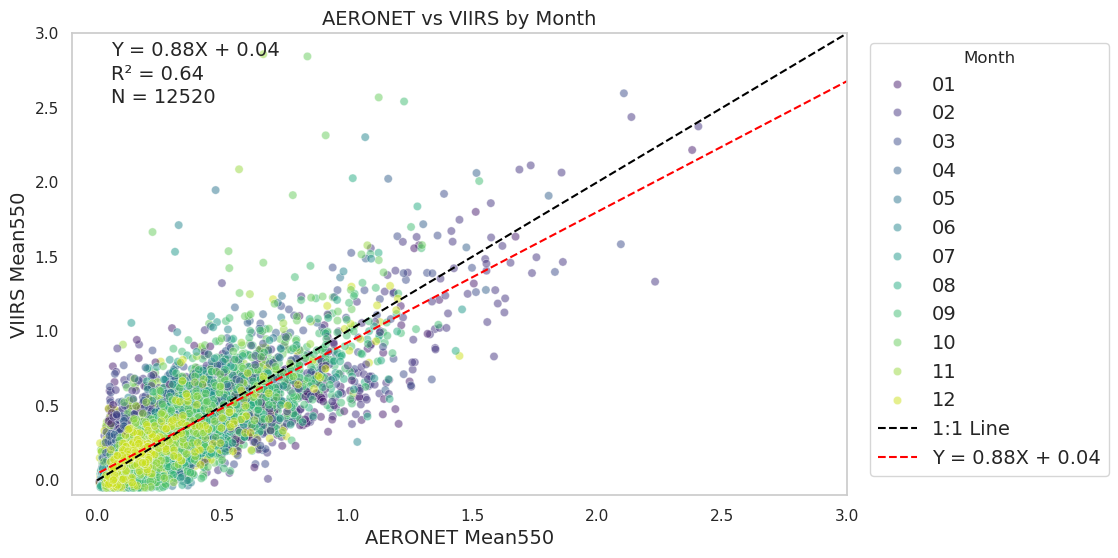

In [268]:
#make scatter plots of the aerMean550 satMean550 color by month
matched_up_df['month']=matched_up_df['date'].str[4:6]
plot_relationship(
    df=matched_up_df,
    x_col='aerMean550',
    y_col='satMean550',
    hue_col='month',
    title='AERONET vs VIIRS by Month',
    xlabel='AERONET Mean550',
    ylabel='VIIRS Mean550',
    legend_title='Month',
    legend_loc='upper right',
    legend_bbox_to_anchor=(1.35, 1),
    legend_ncols=1,
    save_path=os.path.join(plots_dir, 'aeronet_vs_viirs_bymonth.png'),
    regression=True,
    xlim=(-0.1, 3),
    ylim=(-0.1, 3),
    figsize=(10, 6),
    fontsize=14,
    alpha=0.5,
    palette='viridis'
)

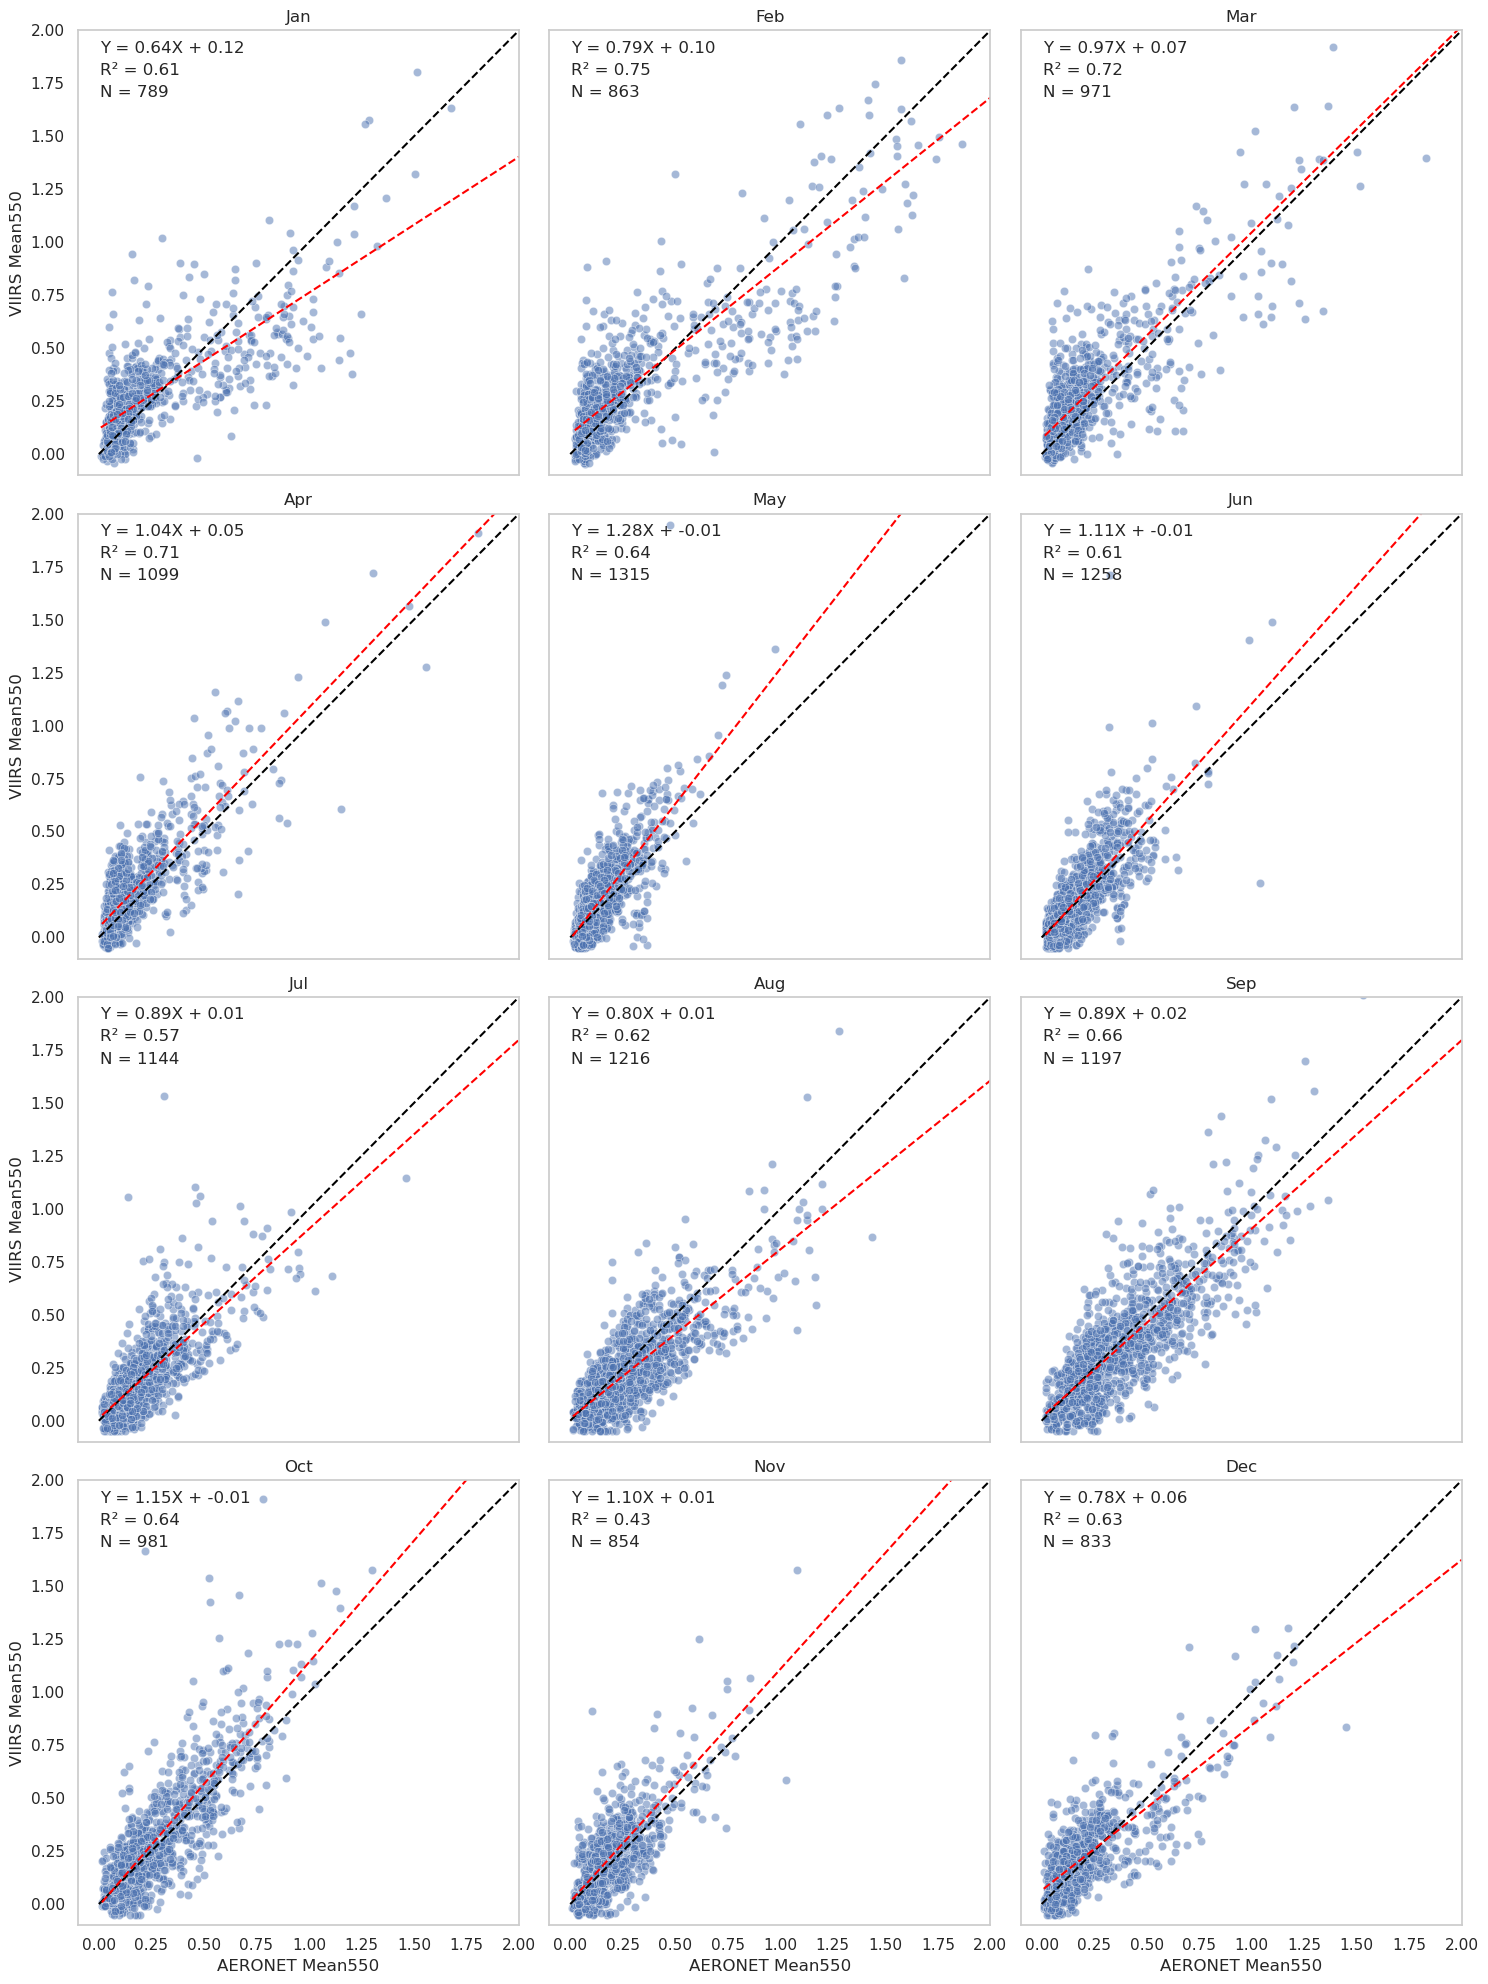

In [272]:
import calendar

# Ensure the 'month' column exists in the DataFrame
unique_months = matched_up_df['month'].unique()
unique_months.sort()

# Create subplots for each month
fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_months) / 3)), ncols=3, figsize=(15, 5 * int(np.ceil(len(unique_months) / 3))), sharex=True, sharey=True)
axes = axes.ravel()

# Loop through each month and plot the data
for i, month in enumerate(unique_months):
    ax = axes[i]
    month_data = matched_up_df[matched_up_df['month'] == month]
    month_name = calendar.month_abbr[int(month)]  # Convert month number to name
    
    # Call the plot_relationship function for the current month
    plot_relationship(
        ax=ax,
        df=month_data,
        x_col='aerMean550',
        y_col='satMean550',
        title=f'{month_name}',
        xlabel='AERONET Mean550',
        ylabel='VIIRS Mean550',
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2),
        ylim=(-0.1, 2),
        alpha=0.5,
        figsize=(6, 6),
        fontsize=12,
        palette=None
    )

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


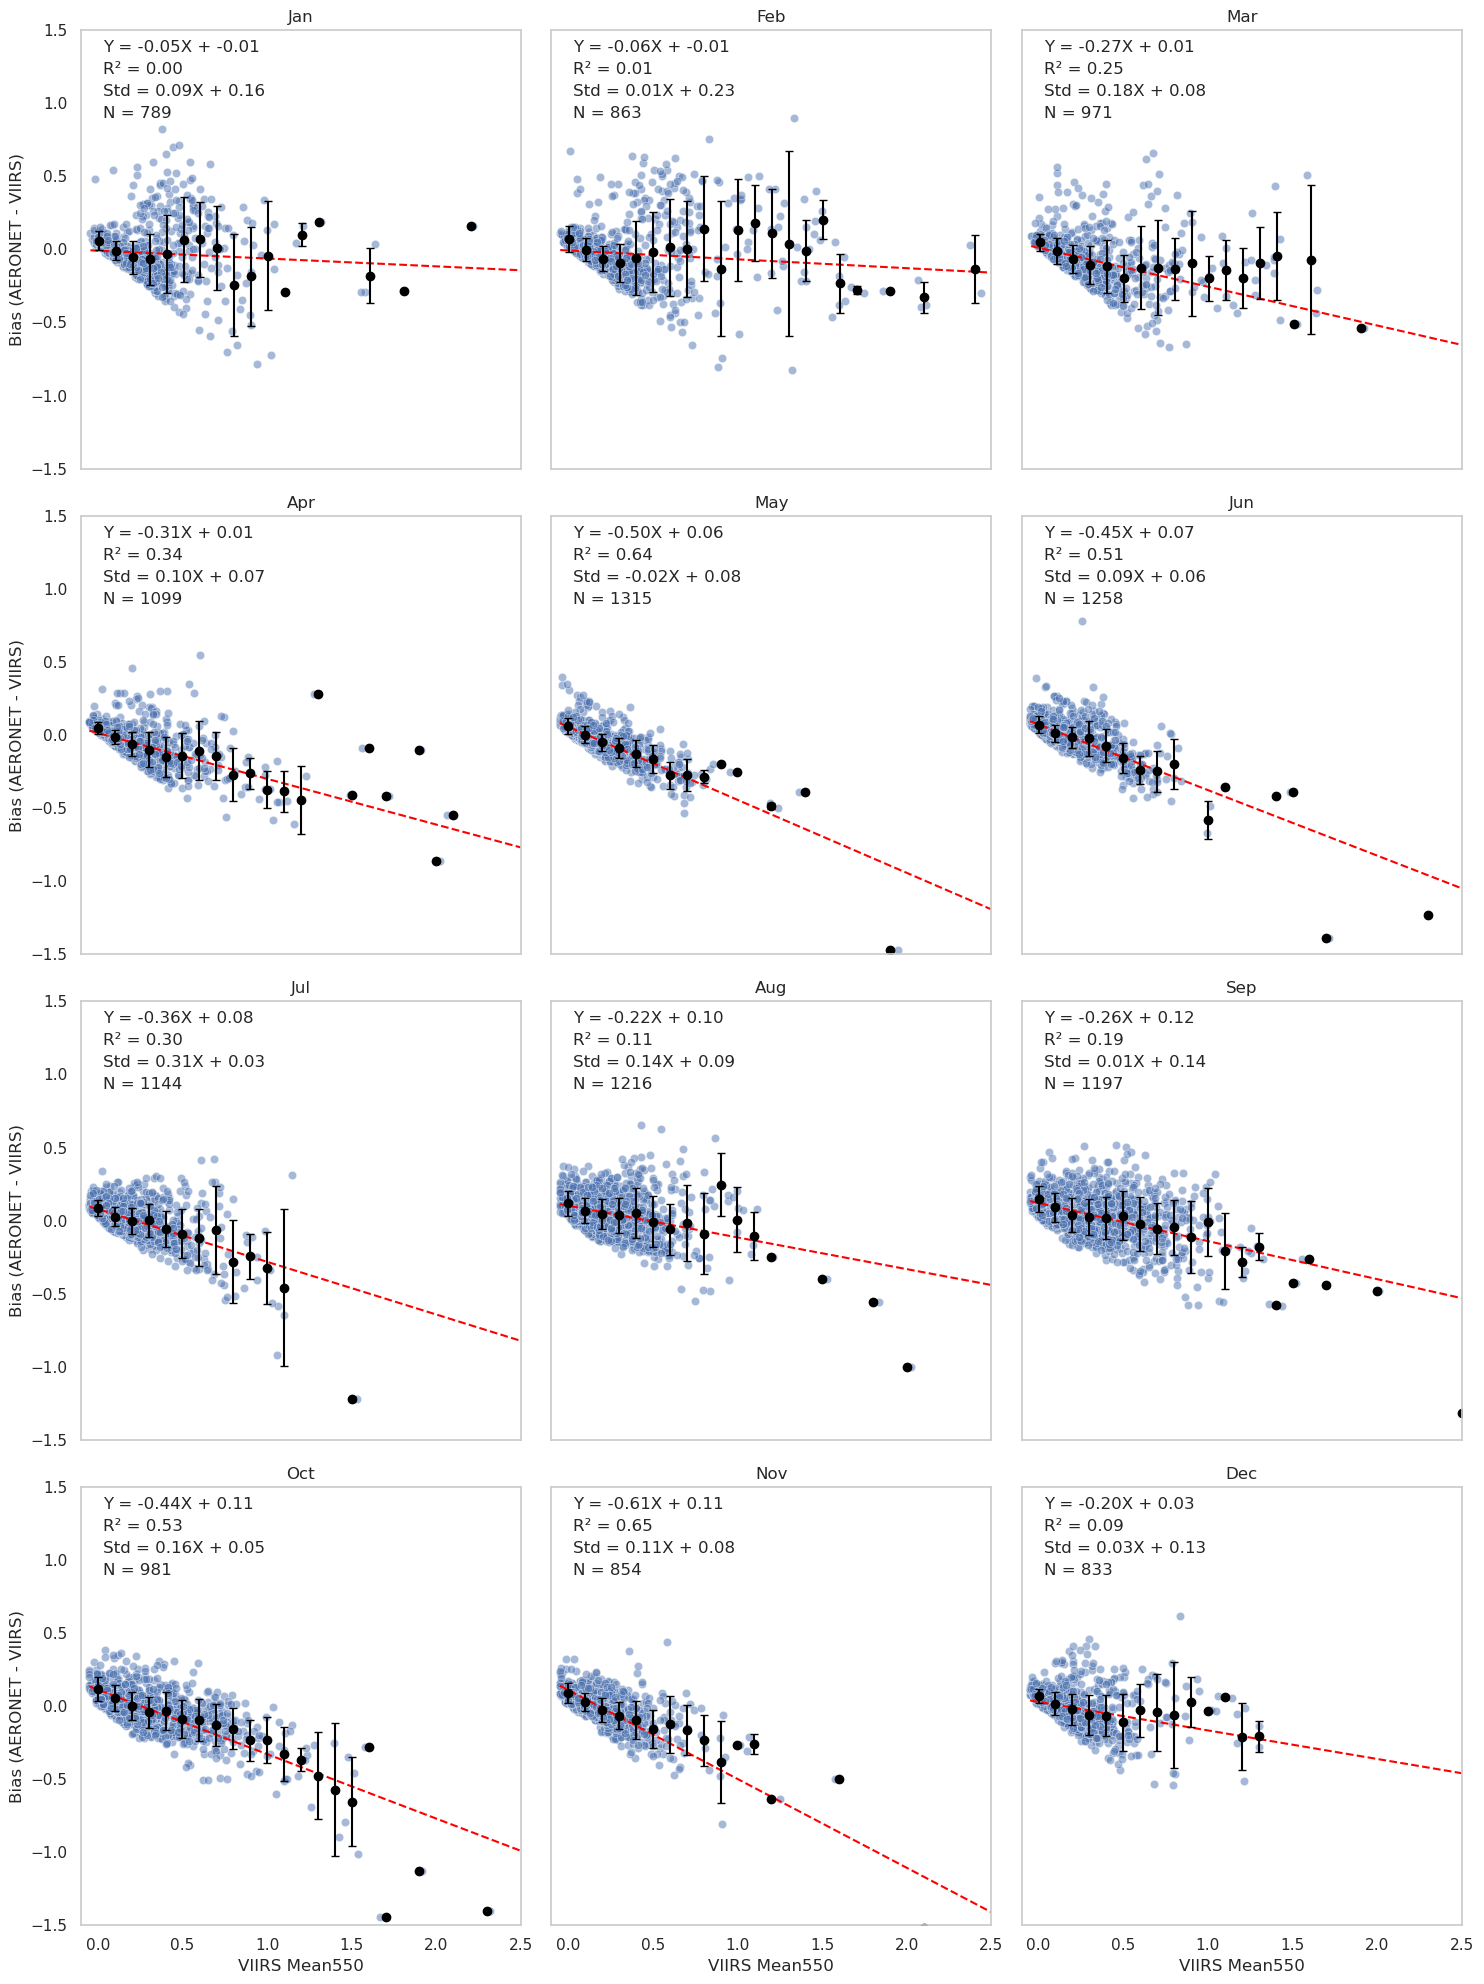

In [310]:
# Ensure the 'month' column exists in the DataFrame
unique_months = matched_up_df['month'].unique()
unique_months.sort()

# Create subplots for each month
fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_months) / 3)), ncols=3, figsize=(15, 5 * int(np.ceil(len(unique_months) / 3))), sharex=True, sharey=True)
axes = axes.ravel()

# Loop through each month and plot the bias
for i, month in enumerate(unique_months):
    ax = axes[i]
    month_data = matched_up_df[matched_up_df['month'] == month]
    month_name = calendar.month_abbr[int(month)]  # Convert month number to name
    
    # Call the plot_relationship function for the current month
    plot_relationship(
        ax=ax,
        df=month_data,
        x_col='satMean550',
        y_col='bias',
        title=f'{month_name}',
        xlabel='VIIRS Mean550',
        ylabel='Bias (AERONET - VIIRS)',
        one_one_line=False,
        plot_error_bar=True,
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-1.5, 1.5),
        alpha=0.5,
        figsize=(6, 6),
        fontsize=12,
        palette=None
    )

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


